# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [45]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [46]:
class Net(nn.Module):
    def __init__(self, hidden_layers):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        hidden_layers.insert(0, 784)
        hidden_layers.append(10)
        self.linears = nn.ModuleList(
            [nn.Linear(i, j) for i, j in zip(hidden_layers[:-1], hidden_layers[1:])])

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i, layer in enumerate(self.linears):
            x = layer(x)
            if i != len(self.linears) - 1:
                x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))

    return torch.tensor([test_loss, test_accuracy])


In [47]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 2e-3
use_cuda = True
seed = 1
log_interval = 10


use_cuda = use_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# Standard training without randomization

In [48]:
# Standard training for comparison
model = Net([128]).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
std_results = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    res = test(model, device, test_loader)
    std_results.append(res)

Test set: Average loss: 0.1682, Accuracy: 9505/10000 (95%)

Test set: Average loss: 0.1154, Accuracy: 9647/10000 (96%)

Test set: Average loss: 0.1002, Accuracy: 9688/10000 (97%)

Test set: Average loss: 0.0972, Accuracy: 9700/10000 (97%)

Test set: Average loss: 0.0969, Accuracy: 9694/10000 (97%)



# Training models in setup 1: with randomized labels.

In [49]:
m = len(dataset1.targets) # number of examples
pixels_per_image = 784
n = 28 # pixels per row/column

X = [0.1, 0.5, 0.618, 0.7, 0.9, 0.95, 0.99]

def randomize_labels(dataset, labels_num):
    indices = torch.randperm(m)[:labels_num]
    new_labels = torch.multinomial(digit_dist, labels_num, replacement=True)
    dataset.targets[indices] = new_labels

digit_dist = torch.bincount(dataset1.targets) / m
old_labels = torch.clone(dataset1.targets)
rand_labels_results = {x:[] for x in X}

for x in X:
    labels_num = int(m * x)
    randomize_labels(dataset1, labels_num)
    model = Net([128]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval)
        res = test(model, device, test_loader)
        rand_labels_results[x].append(res)
    # Restore old labels
    dataset1.targets = torch.clone(old_labels)

Test set: Average loss: 0.3025, Accuracy: 9399/10000 (94%)

Test set: Average loss: 0.2506, Accuracy: 9542/10000 (95%)

Test set: Average loss: 0.2251, Accuracy: 9608/10000 (96%)

Test set: Average loss: 0.2168, Accuracy: 9629/10000 (96%)

Test set: Average loss: 0.2077, Accuracy: 9642/10000 (96%)

Test set: Average loss: 0.8557, Accuracy: 9122/10000 (91%)

Test set: Average loss: 0.7996, Accuracy: 9322/10000 (93%)

Test set: Average loss: 0.7851, Accuracy: 9381/10000 (94%)

Test set: Average loss: 0.7763, Accuracy: 9424/10000 (94%)

Test set: Average loss: 0.7661, Accuracy: 9461/10000 (95%)

Test set: Average loss: 1.1147, Accuracy: 9103/10000 (91%)

Test set: Average loss: 1.0750, Accuracy: 9258/10000 (93%)

Test set: Average loss: 1.0424, Accuracy: 9282/10000 (93%)

Test set: Average loss: 1.0357, Accuracy: 9299/10000 (93%)

Test set: Average loss: 1.0218, Accuracy: 9265/10000 (93%)

Test set: Average loss: 1.2330, Accuracy: 9024/10000 (90%)

Test set: Average loss: 1.2189, Accuracy

# Training models in setup 2: with randomized pixels.

In [50]:
X = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]

def randomize_pixels(dataset, pixels_num):
    for sample in dataset.data:
        indices = torch.randperm(pixels_per_image)[:pixels_num]
        new_pixels = torch.multinomial(pixel_dist, pixels_per_image, replacement=True).byte()
        sample.resize_(pixels_per_image)[indices] = new_pixels[indices]
        sample.resize_(n, n)

        # e = torch.arange(n)
        # indices = torch.stack([e.repeat_interleave(n), torch.cat([e] * n)])
        # indices_for_indices = np.random.choice(pixels_per_image, pixels_num, replace=False)
        # mask = indices.T.resize_(pixels_per_image, 2)[indices_for_indices]
        # mask = mask.T
        # new_pixels = torch.multinomial(pixel_dist, pixels_per_image, replacement=True).byte().resize_(n, n)
        # sample[mask[0], mask[1]] = new_pixels[mask[0], mask[1]]


pixel_dist = torch.bincount(dataset1.targets) / (m * pixels_per_image)
old_samples = torch.clone(dataset1.data)
rand_pixels_results = {x:[] for x in X}

for x in X:
    pixels_num = int(pixels_per_image * x)
    model = Net([128]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        randomize_pixels(dataset1, pixels_num)
        train(model, device, train_loader, optimizer, epoch, log_interval)
        res = test(model, device, test_loader)
        rand_pixels_results[x].append(res)
        # Restore old pixel values
        dataset1.data = torch.clone(old_samples)

Test set: Average loss: 0.1858, Accuracy: 9453/10000 (95%)

Test set: Average loss: 0.1291, Accuracy: 9605/10000 (96%)

Test set: Average loss: 0.1036, Accuracy: 9679/10000 (97%)

Test set: Average loss: 0.0921, Accuracy: 9711/10000 (97%)

Test set: Average loss: 0.0948, Accuracy: 9724/10000 (97%)

Test set: Average loss: 0.3021, Accuracy: 9214/10000 (92%)

Test set: Average loss: 0.1923, Accuracy: 9467/10000 (95%)

Test set: Average loss: 0.1460, Accuracy: 9600/10000 (96%)

Test set: Average loss: 0.1280, Accuracy: 9664/10000 (97%)

Test set: Average loss: 0.1269, Accuracy: 9669/10000 (97%)

Test set: Average loss: 0.5672, Accuracy: 8743/10000 (87%)

Test set: Average loss: 0.3975, Accuracy: 9118/10000 (91%)

Test set: Average loss: 0.2907, Accuracy: 9359/10000 (94%)

Test set: Average loss: 0.2465, Accuracy: 9455/10000 (95%)

Test set: Average loss: 0.2367, Accuracy: 9501/10000 (95%)

Test set: Average loss: 1.7096, Accuracy: 7201/10000 (72%)

Test set: Average loss: 1.7491, Accuracy

# Plots and report.

In [7]:
"""matrix = torch.arange(9).resize(3, 3)

# n = 3
# x = torch.arange(n)
# indices = torch.stack([x.repeat_interleave(n), torch.flatten(x.repeat(n, 1))])
# indices_for_indices = np.random.choice(9, 3, replace=False)
# print(indices_for_indices)
# mask = indices.T.resize(9, 2)[indices_for_indices]
# print(mask)
# mask = mask.T
# print(matrix)
# matrix[mask[0], mask[1]] = 0
# print(matrix)

pixels_per_image = 9
n = 3
x = 4

e = torch.arange(n)
indices = torch.stack([e.repeat_interleave(n), torch.cat([e] * n)])
indices_for_indices = np.random.choice(pixels_per_image, x, replace=False)
mask = indices.T.resize(pixels_per_image, 2)[indices_for_indices]
print(mask)
mask = mask.T
rand_pixels = torch.multinomial(torch.tensor([0.5, 0.25, 0.25]), pixels_per_image, replacement=True).resize(n, n)
print(rand_pixels)
print(matrix)
matrix[mask[0], mask[1]] = rand_pixels[mask[0], mask[1]]
print(matrix)"""

'matrix = torch.arange(9).resize(3, 3)\n\n# n = 3\n# x = torch.arange(n)\n# indices = torch.stack([x.repeat_interleave(n), torch.flatten(x.repeat(n, 1))])\n# indices_for_indices = np.random.choice(9, 3, replace=False)\n# print(indices_for_indices)\n# mask = indices.T.resize(9, 2)[indices_for_indices]\n# print(mask)\n# mask = mask.T\n# print(matrix)\n# matrix[mask[0], mask[1]] = 0\n# print(matrix)\n\npixels_per_image = 9\nn = 3\nx = 4\n\ne = torch.arange(n)\nindices = torch.stack([e.repeat_interleave(n), torch.cat([e] * n)])\nindices_for_indices = np.random.choice(pixels_per_image, x, replace=False)\nmask = indices.T.resize(pixels_per_image, 2)[indices_for_indices]\nprint(mask)\nmask = mask.T\nrand_pixels = torch.multinomial(torch.tensor([0.5, 0.25, 0.25]), pixels_per_image, replacement=True).resize(n, n)\nprint(rand_pixels)\nprint(matrix)\nmatrix[mask[0], mask[1]] = rand_pixels[mask[0], mask[1]]\nprint(matrix)'

In [51]:
# Convert results to tensors to make slicing easier
std_results = torch.stack(std_results)
rand_labels_results = {x:torch.stack(res) for x, res in rand_labels_results.items()}
rand_pixels_results = {x:torch.stack(res) for x, res in rand_pixels_results.items()}

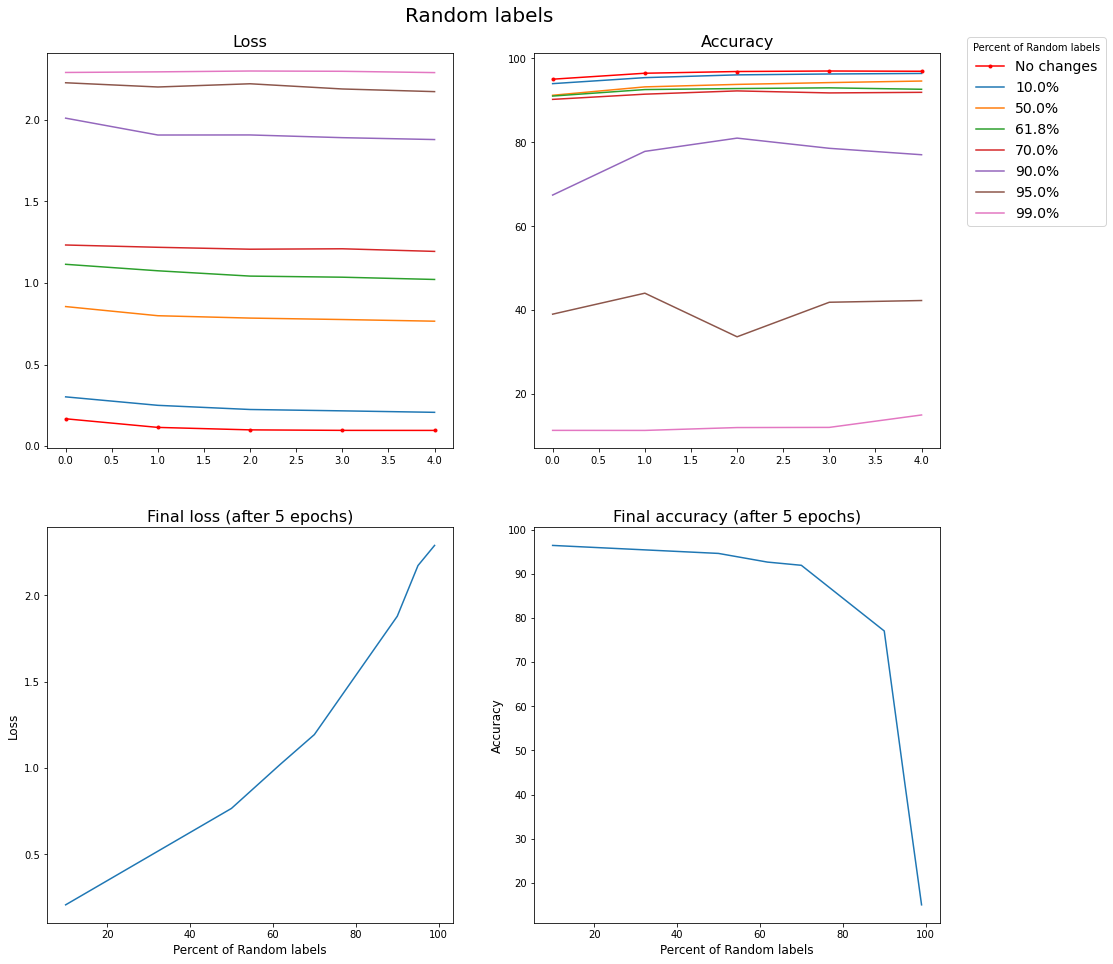

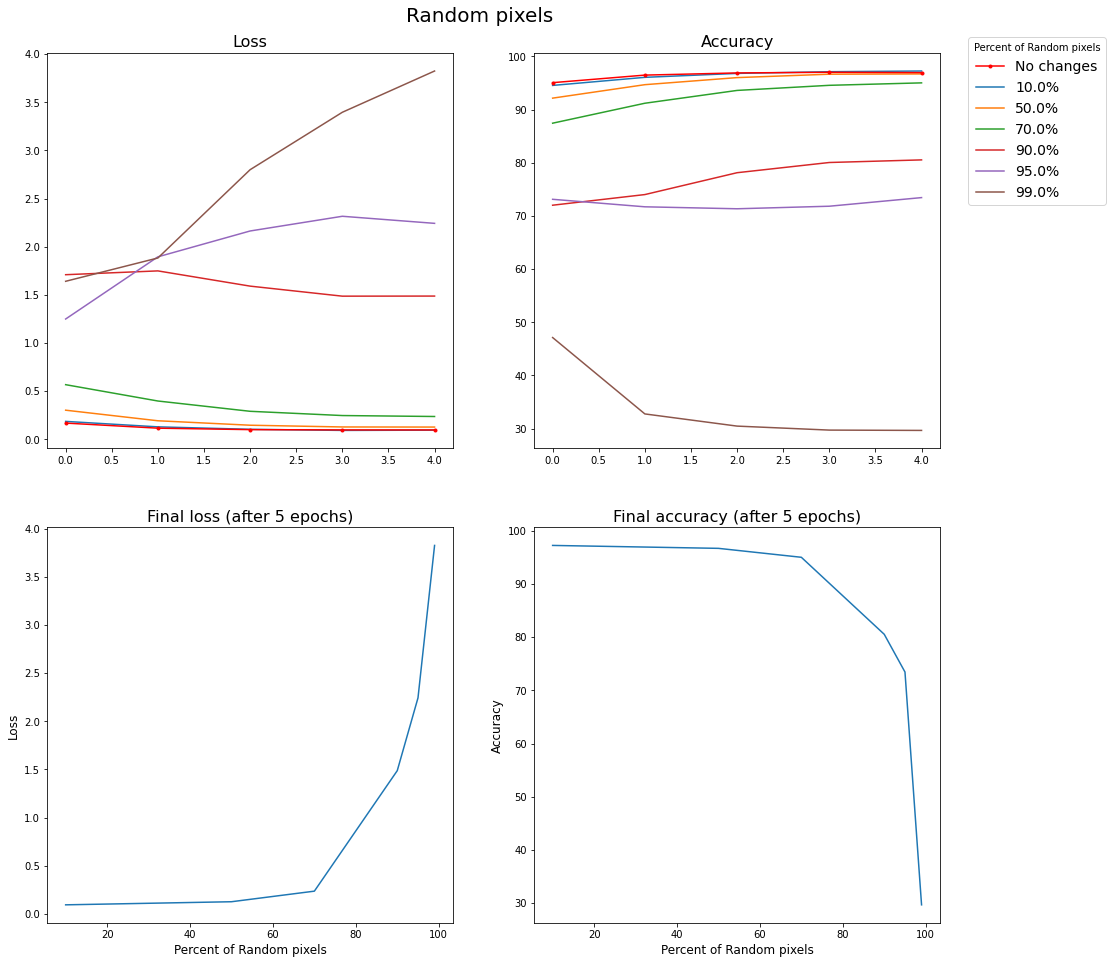

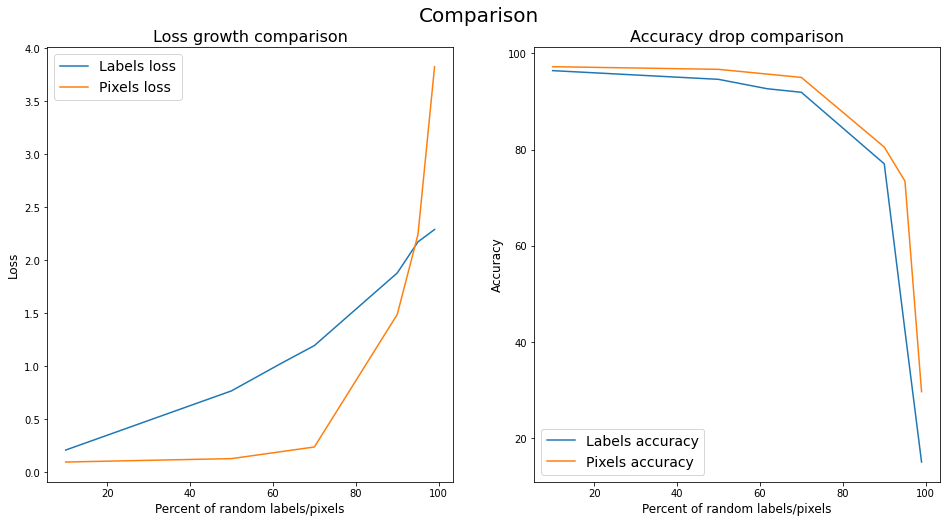

In [52]:
def plot_results(title, std_results, results):
    final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in results.items()])
    fig, ((loss, acc), (final_loss, final_acc)) = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(title, fontsize=20, y=0.92)
    loss.set_title('Loss', size=16)
    acc.set_title('Accuracy', size=16)
    final_loss.set_title('Final loss (after {} epochs)'.format(epochs), size=16)
    final_acc.set_title('Final accuracy (after {} epochs)'.format(epochs), size=16)

    loss.plot(std_results[:, 0], 'r.-', zorder=10, label='No changes')
    acc.plot(std_results[:, 1], 'r.-', zorder=10)

    for x, res in results.items():
        loss.plot(res[:, 0], label='{}%'.format(x * 100.))
        acc.plot(res[:, 1])

    fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9), prop={'size': 14}, title='Percent of {}'.format(title))

    final_loss.plot(final_values[:, 0], final_values[:, 1])
    final_loss.set_xlabel('Percent of {}'.format(title), fontsize=12)
    final_loss.set_ylabel('Loss', fontsize=12)
    final_acc.plot(final_values[:, 0], final_values[:, 2])
    final_acc.set_xlabel('Percent of {}'.format(title), fontsize=12)
    final_acc.set_ylabel('Accuracy', fontsize=12)

    plt.show()

def plot_comparison(rand_labels_results, rand_pixels_results):
    labels_final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in rand_labels_results.items()])
    pixels_final_values = torch.stack([torch.tensor([x * 100., *res[len(res) - 1]]) for x, res in rand_pixels_results.items()])
    fig, (loss_comp, acc_comp) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Comparison', fontsize=20, y=0.95)

    loss_comp.set_title('Loss growth comparison'.format(epochs), size=16)
    loss_comp.plot(labels_final_values[:, 0], labels_final_values[:, 1], label='Labels loss')
    loss_comp.plot(pixels_final_values[:, 0], pixels_final_values[:, 1], label='Pixels loss')
    loss_comp.set_xlabel('Percent of random labels/pixels', fontsize=12)
    loss_comp.set_ylabel('Loss', fontsize=12)
    loss_comp.legend(loc='upper left', prop={'size': 14})

    acc_comp.set_title('Accuracy drop comparison', size=16)
    acc_comp.plot(labels_final_values[:, 0], labels_final_values[:, 2], label='Labels accuracy')
    acc_comp.plot(pixels_final_values[:, 0], pixels_final_values[:, 2], label='Pixels accuracy')
    acc_comp.set_xlabel('Percent of random labels/pixels', fontsize=12)
    acc_comp.set_ylabel('Accuracy', fontsize=12)
    acc_comp.legend(loc='lower left', prop={'size': 14})

    plt.show()


# Random labels
plot_results('Random labels', std_results, rand_labels_results)

# Random pixels
plot_results('Random pixels', std_results, rand_pixels_results)

# Labels vs pixels
plot_comparison(rand_labels_results, rand_pixels_results)

### Random labels
Loss seems to be raising nearly linearly.
Surprisingly, accuracy keeps being above 90% even when 70% of labels have been reassigned. Then it's slowly going down and starts rapidly falling at 90% random labels. Eventually, accuracy reaches 10-11% low (which is basically chance of randomly guessing digit in the picture) for 90% random labels.

### Random pixels
Loss is raising really slowly until 70% random pixels, then growth becomes faster and eventually skyrockets for 85%-90% random pixels. If we imagine that 60% is 0, percents <60% are negative and percents >60% are positive then it seems fairly similar to exponential functions.
Initially, accuracy behaves similarly as for random labels. Interesting is fact that, even for 99% pixels randomly changed, the accuracy is still much higher than 10% (between 30% and 50%).

### Conclusions from both experiments
1. For random labels, even though loss raises steadily, the accuracy is stays pretty high by most of the time. Reason is the way that accuracy works - it always selects highest final score. E.g. for 10% random labels, in final layer, we can get [0=0.01, 1=0.02, ..., k=0.89, ..., 9=0.02], whereas for 70% we may get [0=0.18, 1=0.09, ..., k=0.28, ..., 9=0.12]. In both situations k is selected.
It is because, on average, k will still get $1 - x$ score and other values will get $(x / 9)$ score. It's clear that $1 - x = x / 9$ for $x = 0.9$ and that is also around that moment when accuracy on the chart is dropping rapidly. The reason why we have any drop of accuracy for $x < 0.9$ is probably uneven distribution of noise between batches.
2. Accuracy drops faster for random pixels than labels. But when we look on digit images from dataset it becomes clear what is happening. Distribution of pixels in the initial training set looks like this: most of the pixels are black, many pixels are white and there is very small number of pixels of color between black and white.
And we sample exactly from this distribution so most of the time we change black pixels to black pixels. Sometimes we introduce a bit of a white noise across the background and sometimes we change very small parts of numbers to black.
In a result, pixel changes seem to be less significant for model performance than label changes.
3. Accuracy way higher than 10% for 99% random pixels may also be result of above. Even when changing nearly all the pixels, the remaining ones may still hold certain pattern that these digits may remain recognizable.
## Check this before submitting 4. Around 90% of random pixels the picture is probably becoming really noisy and may not look like any digit. Because model doesn't have option "None of {0, 1, ..., 9}" so it may give nearly equal scores to all digits. Because of the way that log-loss and specifically logarithm function works (e.g. sum of [log(1.1), log(1.1), log(1.1), log(1.1), log(1.1)] is greater than log(1.5)) it may lead to situation when we get maximum loss for some examples which may drive average loss growth even though accuracy is quite high.